In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install scikeras

In [ ]:
data_path = '/content/drive/My Drive/archive/'

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
# Directory paths
train_dir = data_path + 'train/'
test_dir = data_path + 'test/'

In [ ]:
# Define image dimensions and batch size
img_width, img_height = 32,32
batch_size = 16

In [ ]:
# Create ImageDataGenerator for training and testing data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Generate training and testing datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 24186 images belonging to 5 classes.
Found 6043 images belonging to 5 classes.


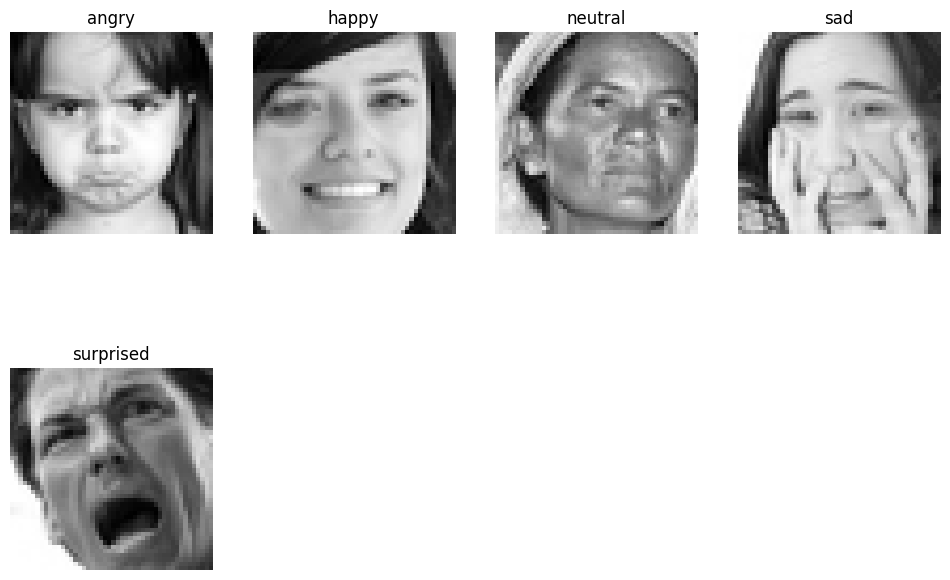

In [ ]:
# Display sample images for different emotions
emotions = ['angry', 'happy', 'neutral', 'sad', 'surprised']

plt.figure(figsize=(12, 8))
for i, emotion in enumerate(emotions, start=1):
    img_path = os.path.join(train_dir, emotion, os.listdir(os.path.join(train_dir, emotion))[0])
    img = mpimg.imread(img_path)
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

plt.show()

In [ ]:
def create_model(optimizer='adam', dropout_rate=0.5):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Create a KerasClassifier based on the defined model
model = KerasClassifier(build_fn=create_model, verbose=0, dropout_rate=0.3)

In [ ]:
# Define the grid of hyperparameters to search
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5, 0.7]
}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Perform grid search cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(train_generator, validation_data=test_generator, callbacks=[early_stopping])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


ValueError: 
All the 18 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 684, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: KerasClassifier.fit() missing 1 required positional argument: 'y'


In [ ]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Retrieve the best model from grid search
best_model = grid_result.best_estimator_.model

In [ ]:
# Evaluate the best model
loss, accuracy = best_model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plotting loss and accuracy
plt.plot(best_model.history.history['loss'], label='train loss')
plt.plot(best_model.history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
plt.plot(best_model.history.history['accuracy'], label='train accuracy')
plt.plot(best_model.history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
def predict_emotion(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height), color_mode='grayscale')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    emotion_labels = ['angry', 'happy', 'neutral', 'sad', 'surprised']
    predicted_class = np.argmax(prediction)
    predicted_emotion = emotion_labels[predicted_class]
    return predicted_emotion

In [ ]:
# Load and display the specified image
img = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/archive/test/happy/im1014.png', target_size=(img_width, img_height), color_mode='grayscale')
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array /= 255.0  # Normalize pixel values to [0, 1]
# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Predict emotion for the specified image
prediction = predict_emotion('/content/drive/MyDrive/archive/test/happy/im1014.png')
print("Predicted Emotion:", prediction)

In [ ]:
model.save('emotion_detection_model.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained Keras model
model = load_model('emotion_detection_model.h5')

# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set optimization flags for smaller model size
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the converted TensorFlow Lite model
with open('emotion_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
%pip install opencv-python-headless

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from base64 import b64decode

# Load the emotion detection model
model = load_model('emotion_detection_model.h5')

# Define emotion labels
emotion_labels = ['angry', 'happy', 'neutral', 'sad', 'surprised']

# Function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
    """
    Params:
            js_reply: JavaScript object containing image from webcam
    Returns:
            img: OpenCV BGR image
    """
    # Decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # Convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # Decode numpy array into OpenCV BGR image
    img = cv2.imdecode(jpg_as_np, flags=1)

    return img

# JavaScript to properly create our live video stream using our webcam as input
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    # get photo data
    data = eval_js('takePhoto({})'.format(quality))
    # get OpenCV format image
    img = js_to_image(data)
    if img is not None:
        # save image
        cv2.imwrite(filename, img)
        print('Saved to {}'.format(filename))
        return filename
    else:
        return None

# Use the `take_photo` function to capture an image from the webcam
try:
    filename = take_photo() # you can pass the filename here if you want to choose it
    if filename:
        # Show the image which was just taken.
        display(Image(filename))
        # Predict the emotion on the captured image
        emotion = predict_emotion(filename)
        print("Predicted Emotion:", emotion)
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # allow the website to access it.
    print("Error:", str(err))

# Now that we have the image, we can preprocess it and use our model to predict the emotion
def predict_emotion(image_path):
    img = image.load_img(image_path, target_size=(32, 32), color_mode='grayscale')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255
    prediction = model.predict(img)
    emotion = emotion_labels[np.argmax(prediction)]
    return emotion

